# Coursera - Regression Project 

#### By Mandy Jiang  (03/22/2022) 

## Executive Summary

We are going to explore the relationship between a set of variables and miles per gallon (MPG) (outcome), and try to answer two questions: (1) Is an automatic or manual transmission better for MPG; (2) Quantify the MPG difference between automatic and manual transmissions. Using mtcars for this project; checking details with ?mtcars. For model, outcome: mpg (miles/gallon); variable: am (transmission (0 = automatic, 1 = manual)).

We show that manual transmission has mpg 1.56 greater than automatic transmission, which make it sounds like automatic cars are better for MPG. However, this difference becomes marginal if removing 3 outlier samples, which increase the uncertainty of the answers. We need to add more data points in the future study to see whether this model performance or the conclusions are robust with more data points added or removed.

In [43]:
library(dplyr)
library(ggplot2)
library(car)

### Exploratory data analysis

Basic statistics shows that the manual cars has higher mpg (in both mean and median) than the automatic cars but with more variances in the data.

In [72]:
mtcars %>%
  group_by(am) %>%
  summarise(mean = mean(mpg), median = median(mpg), min = min(mpg), max = max(mpg), sd=sd(mpg), n = n())

am,mean,median,min,max,sd,n
0,17.14737,17.3,10.4,24.4,3.833966,19
1,24.39231,22.8,15.0,33.9,6.166504,13


We hypothesize that there is no difference in mpg between manual and automatic cars. However, by t-test, we find that p=0.001374 < 0.05 and 95% confident interval doesn't include 0, indicating that mpg in manual cars is significantly higher than the one in automatic cars.

In [98]:
t.test(mtcars$mpg[mtcars$am == "0"],mtcars$mpg[mtcars$am == "1"], paired=FALSE)


	Welch Two Sample t-test

data:  mtcars$mpg[mtcars$am == "0"] and mtcars$mpg[mtcars$am == "1"]
t = -3.7671, df = 18.332, p-value = 0.001374
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -11.280194  -3.209684
sample estimates:
mean of x mean of y 
 17.14737  24.39231 


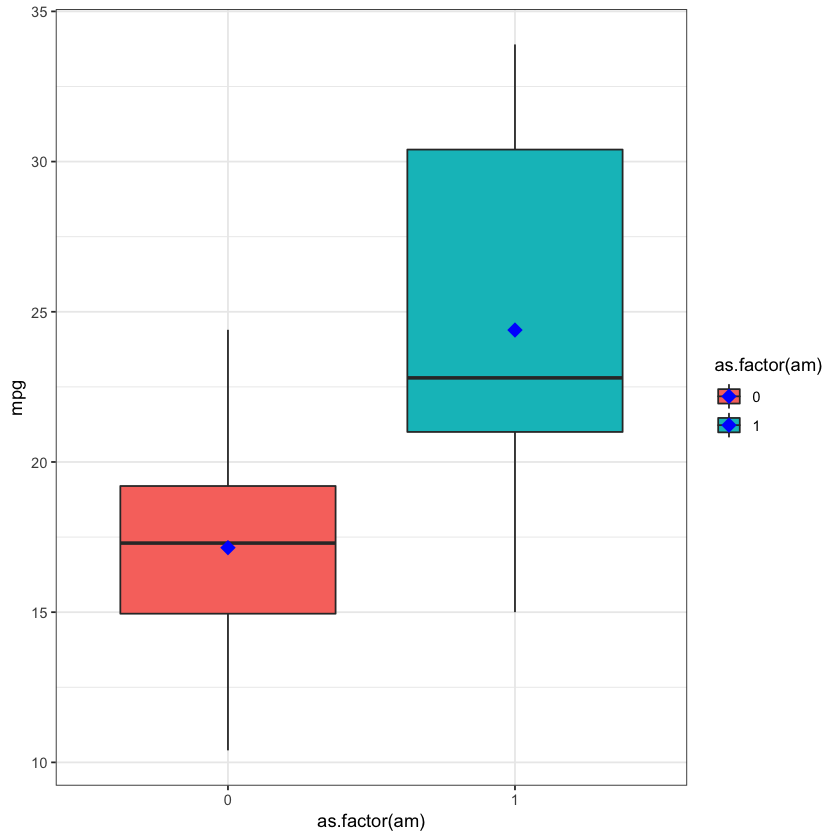

In [105]:
library(ggplot2)
p = ggplot(mtcars, aes(x=as.factor(am), y=mpg, fill=as.factor(am))) +
  geom_boxplot()+
  stat_summary(fun.y=mean, geom="point", shape=18, size=4, color="blue",position=position_dodge(0.75))+
  theme_bw()
options(p.plot.width = 0.5, p.plot.height = 0.5)
p

### Simple model mpg ~ am

We then fit a linear model with am as the only predictor and see how it regressed with mpg. Model fit1: mpg = beta0+beta1*am, beta0=17.147 and beta1=7.245, both are statistically significant. The coefficients tell us that (1) if am=0,ie. automatic cars, the average mpg is 17.147 miles/gallon; (2) if am=1, ie. manual cars, the average mpg is 7.245 more than the one in automatic cars.

In [101]:
fit1 = lm(mpg~factor(am),data=mtcars)
summary(fit1)


Call:
lm(formula = mpg ~ factor(am), data = mtcars)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.3923 -3.0923 -0.2974  3.2439  9.5077 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   17.147      1.125  15.247 1.13e-15 ***
factor(am)1    7.245      1.764   4.106 0.000285 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.902 on 30 degrees of freedom
Multiple R-squared:  0.3598,	Adjusted R-squared:  0.3385 
F-statistic: 16.86 on 1 and 30 DF,  p-value: 0.000285


However, the adjusted r squared is 0.3385, indicating fit1 only explains ~33.9% of the data. We need to build a multivariate linear regression model to improve the performance.

### Updated model mpg ~ more predictors

To improve the performance of the model, we are going to add more predictors. We look at the correlation between mpg and other variables, and pick up the ones having the highest correlation with mpg, including cyl, disp, hp, wt.

In [82]:
mtcarsCorr=cor(mtcars[sapply(mtcars, is.numeric)])
t(mtcarsCorr[1,])

mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
1,-0.852162,-0.8475514,-0.7761684,0.6811719,-0.8676594,0.418684,0.6640389,0.5998324,0.4802848,-0.5509251


#### Model selection

We set up two models, (1) fit2 includes predicators as am, cyl, disp, hp and wt; (2) fit3 includes the same predictors
as fit2, but factorize both am and cyl. By comparing adjusted r squared and residual variance, fit3 performs better than fit2.

In [87]:
fit2 = lm(mpg~factor(am)+cyl+disp+hp+wt,data=mtcars)
summary(fit2)$adj.r.squared
summary(fit2)$sigma
fit3 = lm(mpg~factor(am)+factor(cyl)+disp+hp+wt,data=mtcars)
summary(fit3)$adj.r.squared
summary(fit3)$sigma

[1] 0.8272816

[1] 2.504764

[1] 0.8343702

[1] 2.452825

We continue perform anova analysis on fit1, fit2, and fit3, to understand whether adding more predictors and factorizing the variables will improve the model significantly. It turns out adding new variables can improve the model significantly, with P=4.210309e-08; however, factorizing the varibles doesn't help too much, with P=1.585156e-01 >0.05. Thus, we can stick to fit2 model for downstream residual analysis.

In [84]:
anova(fit1, fit2, fit3)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
30,720.8966,NA,NA,NA,NA
26,163.1199,4,557.77675,23.177530,4.210309e-08
25,150.4088,1,12.71105,2.112749,1.585156e-01


#### Residual analysis

We look at the residuals distribution along with the fitted values to confirm that the variance of residuals is homoskedastic. Also, based on Q-Q plot, we further confirm the residuals are normally distributed in fit2.

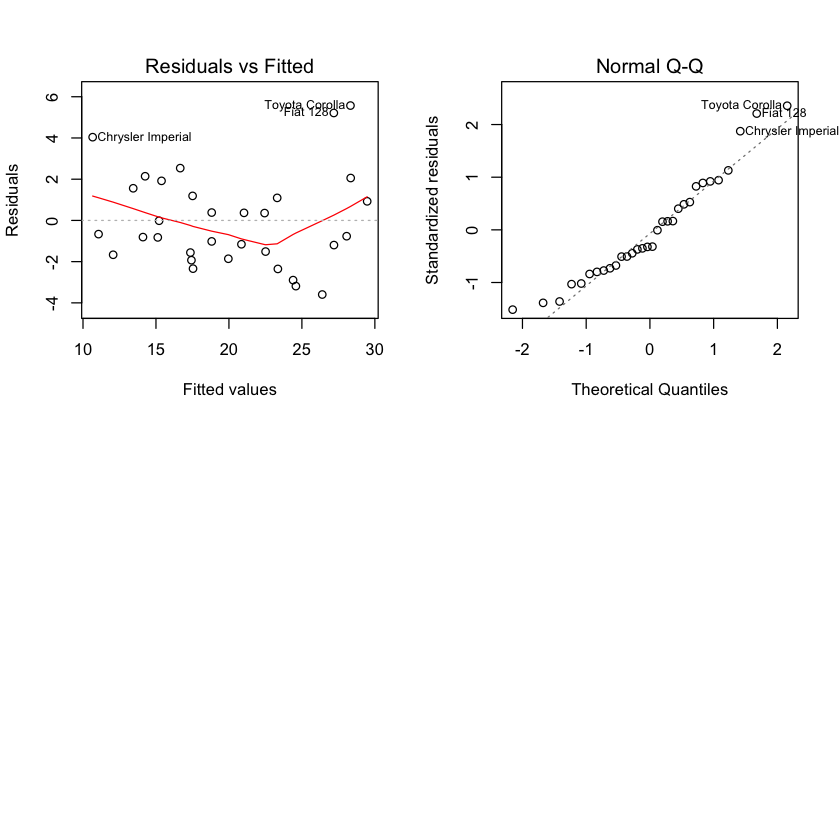

In [91]:
par(mfrow = c(2,2))
plot(fit2, which =c(1,2))

#### Removing outlier samples

We find 3 outlier samples from the residual analysis, including Chrysler Imperial, Toyota Corolla and Fiat 128. We set up model fit4 to observe the performance after removing these samples, and it shows that fit4 improve the adjusted r squared from 0.827 to 0.883, with lower residual variances. 

In [95]:
# which(rownames(mtcars) == "Toyota Corolla")  
fit4 = lm(mpg~factor(am)+cyl+disp+hp+wt,data=mtcars[-c(17,18,20),])
summary(fit4)$adj.r.squared
summary(fit4)$sigma

[1] 0.883025

[1] 1.758206

#### Uncertainty in model performance

We compare coefficient beta1 in model fit1, fit2 and fit4 to understand how many mpg is increased in manual cars compared with the automatic cars. In single variable model fit1, manual transmission has about mpg 7.24 greater than an automatic transmission. However, in multivariate model fit2, manual transmission only has mpg 1.56 greater than automatic transmission; and this number keeps decreasing to 0.13 in model fit4 with only 3 outlier samples get removed.

In [108]:
rbind("fit1" = c("beta1" = summary(fit1)$coef[2,1]),
      "fit2" = summary(fit2)$coef[2,1],
      "fit4" = summary(fit4)$coef[2,1])

,beta1
fit1,7.2449393
fit2,1.5564916
fit4,0.1338069


This tells us that (1) when considering more varaibles to the model, the advantage of automatic transmission over manual transmission becomes smaller; (2) with only 3 outliers removal, the mpg difference between automatic and manual cars is below 1, indicating similar performance between automatic and manual transmission. It is hard to tell which one is better and we need more sample points to be trained in the model to further look at the difference.